# Torque simulations

\begin{equation}
    \tau = m \times B = \mu_0 m \times (H_{app}+H_{demag})
\end{equation}

### Importing Packages

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

Increase applied field -> less sheered sin wave
Add general rotation about an axis
Fit curves and check against initial K values

In [2]:
region = df.Region(p1=(0, 0, 0), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.CubicAnisotropy(K=0.8e6, u1=(0, 0, 1), u2=(0, 1, 0))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))
Ms = 384e3

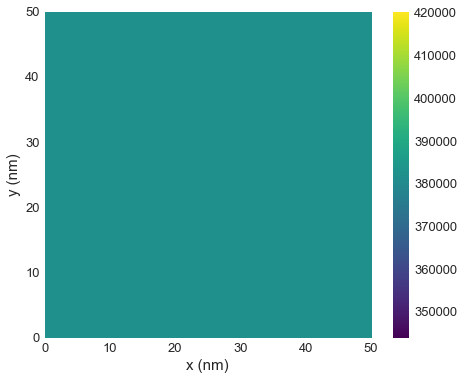

In [15]:
system.m = df.Field(mesh, dim=3, value=(0,0.1,1), norm=Ms)
system.m.z.plane('z').mpl.plot()

In [19]:
def magentisation_parallel(field):
    return df.integral(field.z * df.dV, direction='xyz')

def magentisation_perpendicular(field):
    return (df.integral(field.x * df.dV, direction='xyz'),
           df.integral(field.y * df.dV, direction='xyz'))

In [20]:
mp = magentisation_perpendicular(system.m)

In [21]:
mp

(0.0, 4.776178513007951e-18)

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [2]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.CubicAnisotropy(K=0.8e6, u1=(0, 0, 1), u2=(0, 1, 0))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))
Ms = 384e3

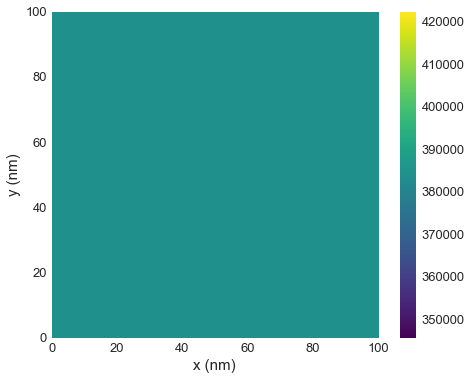

In [3]:
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
system.m.z.plane('z').mpl.plot()

In [4]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.7 s)


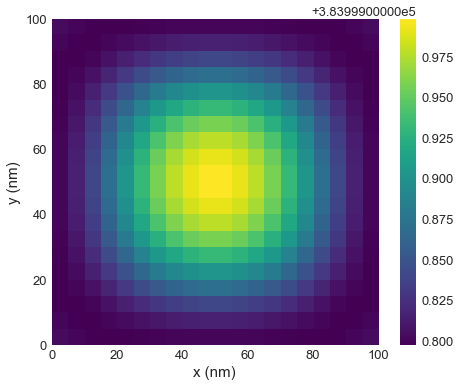

In [5]:
system.m.z.plane('z').mpl.plot()

In [6]:
def torque(system):
    total_field = oc.compute(system.energy.demag.effective_field, system) + system.energy.zeeman.H
    torque = 4*np.pi*1e-7*(system.m & total_field)
    return (torque.x.array.sum(),torque.y.array.sum(),torque.z.array.sum()) # Some sort of normalisation

In [19]:
H_mag = 10e4
print(4*np.pi*1e-7*H_mag)

0.12566370614359174


In [7]:
angles = np.linspace(0, 2*np.pi, 70)
H_mag = 10e6



torque_val_x = np.zeros_like(angles)
torque_val_y = np.zeros_like(angles)
torque_val_z = np.zeros_like(angles)

for i, angle in enumerate(angles):
        system.energy.zeeman.H= (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
        md.drive(system)
        torque_val_x[i], torque_val_y[i], torque_val_z[i] = torque(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:49]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:50]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/

In [8]:
from scipy.optimize import curve_fit
def fun(angle, a,b,c,d):
    return a*np.sin(4*angle) + b*np.sin(8*angle) + c*np.sin(16*angle) + d*np.sin(32*angle)

In [9]:
popt, pcov = curve_fit(fun, angles, torque_val_x, p0=[-1e15, 1e14, 1e14, -1e14])

In [10]:
popt

array([-3.15586038e+09,  5.11455765e+08,  3.55196627e+07,  4.56921404e+05])

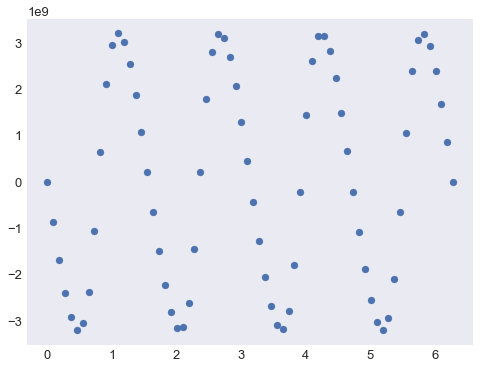

In [11]:
plt.scatter(angles, torque_val_x)
#plt.plot(angles, fun(angles,popt[0],popt[1], popt[2], popt[3]))

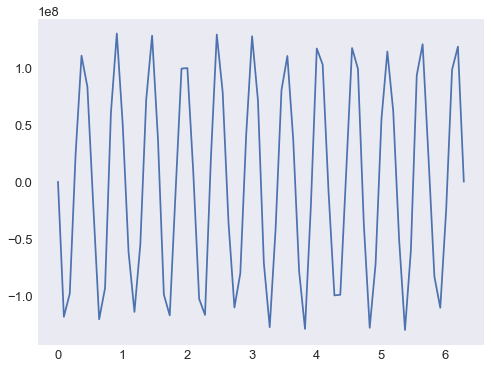

In [12]:
plt.plot(angles, torque_val_x - fun(angles,popt[0],popt[1], popt[2], popt[3]))

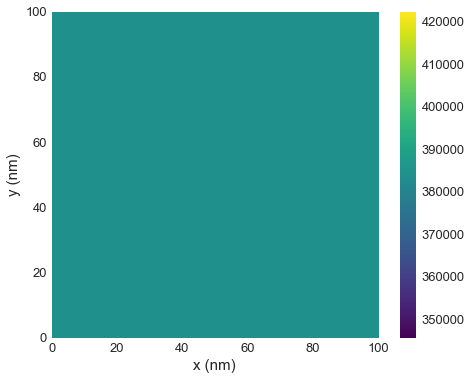

In [13]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))
Ms = 384e3
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
#system.m.z.plane('z').mpl.plot()
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
system.m.z.plane('z').mpl.plot()

In [14]:
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.0 s)


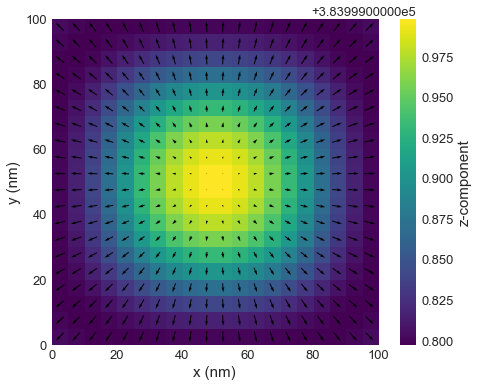

In [15]:
system.m.plane('z').mpl.plot()

In [16]:
angles = np.linspace(0, 2*np.pi, 70)
H_mag = 10e6



torque_val_x = np.zeros_like(angles)
torque_val_y = np.zeros_like(angles)
torque_val_z = np.zeros_like(angles)

for i, angle in enumerate(angles):
        system.energy.zeeman.H= (0,H_mag*np.sin(angle),H_mag*np.cos(angle))
        md.drive(system)
        torque_val_x[i], torque_val_y[i], torque_val_z[i] = torque(system)

Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:56]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:57]... (2.2 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:57]... (2.0 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:57]... (2.2 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:57]... (2.1 s)
Running OOMMF (DockerOOMMFRunner) [2021/07/23 11:57]... (2.2 s)
Running OOMMF (DockerOOMMFRunner) [2021/

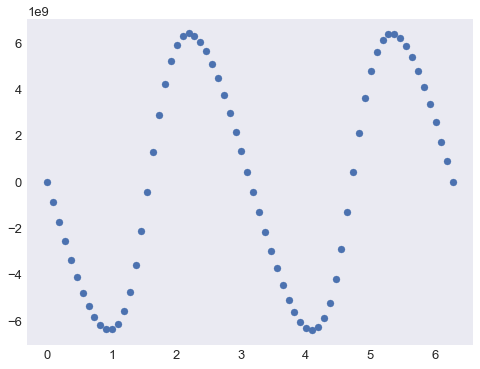

In [17]:
plt.scatter(angles, torque_val_x)